In [1]:
%load_ext blackcellmagic

In [2]:
import os
os.chdir("..")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
from tqdm.auto import tqdm  
import warnings

warnings.filterwarnings("ignore")

# Evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
# Stratified sampling for multi-label classification
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection import IterativeStratification
# Classifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
# Other
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [4]:
pd.set_option("display.max_rows", 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

## 1. Load and transform data

In [5]:
df = pd.read_pickle('data/processed/reports_tokenized.p')
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text,CSR_Text_clean,CSR_Text_tokenized
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,888 HOLDINGS PLC\n\nANNUAL REPORT & ACCOUNTS 2020\n\n A YEAR OF \nSTRONG GROWTH \n\n888 IS ONE ...,HOLDINGS PLC ANNUAL REPORT & ACCOUNTS 2020 A YEAR OF STRONG GROWTH 888 IS ONE OF THE WORLDS LEA...,holding plc annual report account year strong growth one world leading online betting gaming com...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on \nour Promises\n\n2020 Corporate Social Responsibility Report\n\n1\n\n Letter fro...,Delivering on our Promises 2020 Corporate Social Responsibility Report 1 Letter from the Presid...,delivering promise corporate social responsibility report letter president stakeholder engagemen...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8154,12676,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2016 T A B L E ...,e n v r n e n l c l g v e r n n c e sustainability report b l e f c n e n company profile corpor...
8155,12677,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2015 Investing ...,e n v r n e n l c l g v e r n n c e sustainability report investing future world b l e f c n e n...


In [ ]:
# Data: tf-idf
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['CSR_Text_tokenized'])

# Labels: Exclude SDGs 10 and 14
labels = ['SDG_1', 'SDG_2', 'SDG_3', 'SDG_4', 'SDG_5', 'SDG_6', 'SDG_7', 'SDG_8', 'SDG_9', 'SDG_11', 'SDG_12', 'SDG_13', 'SDG_15', 'SDG_16', 'SDG_17']
Y = df[labels].to_numpy().astype(int)

In [ ]:
# Split into training and test data (stratified for multi-label)
X_train, Y_train, X_test, Y_test = iterative_train_test_split(X, Y, test_size = 0.2)

## 2. Classification without prior balancing of the data
(without prior balancing of the data)

In [67]:
# Perform Grid Search to find optimal parameters (NO STRATIFIED SAMPLING IN GRID SEARCH?)
# TRY TO USE STRATIFIEDSAMPLER

# OVR: Transform Y into single labels 
ovr = OneVsRestClassifier(LogisticRegression())

parameters = {'estimator__C': [1,2]}

scorer = make_scorer(f1_score, average = 'weighted')

grid_search = GridSearchCV(ovr, parameters, cv=2, scoring=scorer, n_jobs=-1, verbose=2)

grid_search.fit(X_train, Y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


GridSearchCV(cv=2,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1, param_grid={'estimator__C': [1, 2]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [68]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

{'estimator__C': 2}
OneVsRestClassifier(estimator=LogisticRegression(C=2))
0.8340912090497399


              precision    recall  f1-score   support

           0       0.83      0.46      0.59       209
           1       1.00      0.09      0.17        22
           2       0.81      0.99      0.89      1506
           3       0.79      1.00      0.88      1463
           4       0.75      0.98      0.85      1319
           5       0.83      0.96      0.89      1422
           6       0.80      0.95      0.86      1324
           7       0.76      0.95      0.85      1229
           8       0.67      0.20      0.31        40
           9       0.82      0.46      0.59       201
          10       0.85      0.99      0.91      1560
          11       0.77      0.85      0.81      1150
          12       0.84      0.68      0.75       581
          13       0.75      0.96      0.85      1257
          14       0.82      0.46      0.59       201

   micro avg       0.79      0.92      0.85     13484
   macro avg       0.80      0.73      0.72     13484
weighted avg       0.80   

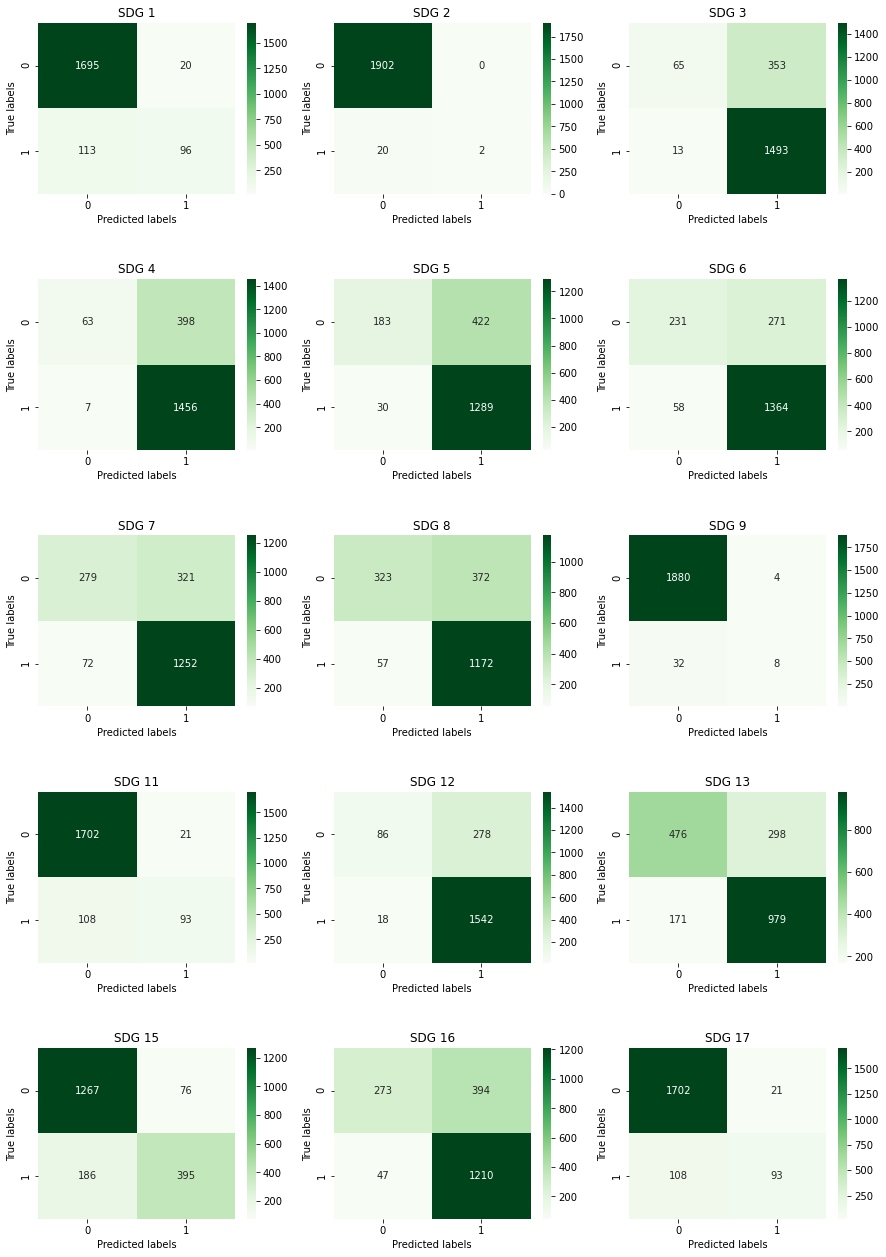

In [70]:
# Evaluation
predictions = grid_search.predict(X_test)
print(classification_report(Y_test, predictions))

sdgs = [1,2,3,4,5,6,7,8,9,11,12,13,15,16,17]
counter = 0
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,22))
plt.subplots_adjust(hspace = 0.5)
for ax in axes.flatten():
    cm = confusion_matrix(Y_test[:,counter], predictions[:,counter])
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Greens')
    ax.set_title('SDG ' + str(sdgs[counter]))
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    counter += 1

## 3. Classification with Pipeline to balance data using SMOTE
- in each iteration of cross validation:
- split in 15 train and validation sets with 1 label each
- over- / undersample training set for each set and train classifier
- ToDo: combine smote with undersampling: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [31]:
# Perform Grid Search to find optimal parameters (NO STRATIFIED SAMPLING IN GRID SEARCH?)
# TRY TO USE STRATIFIEDSAMPLER

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# Pipeline: Resample data with smote and pass output to classifier
pipeline = Pipeline([('smote', SMOTE(k_neighbors = 2)), # delete k_neighbors for full data
                     ('clf', LogisticRegression())])

# OVR: Transform Y into single labels and pass single label data to different copies of pipeline
ovr = OneVsRestClassifier(pipeline)

parameters = {'estimator__clf__C': [1,2]}

scorer = make_scorer(f1_score, average = 'weighted')

grid_search = GridSearchCV(ovr, parameters, cv=2, scoring=scorer, n_jobs=-1, verbose=2)

grid_search.fit(X_train, Y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


GridSearchCV(cv=2,
             estimator=OneVsRestClassifier(estimator=Pipeline(steps=[('smote',
                                                                      SMOTE(k_neighbors=2)),
                                                                     ('clf',
                                                                      LogisticRegression())])),
             n_jobs=-1, param_grid={'estimator__clf__C': [1, 2]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [32]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

{'estimator__clf__C': 2}
OneVsRestClassifier(estimator=Pipeline(steps=[('smote', SMOTE(k_neighbors=2)),
                                              ('clf',
                                               LogisticRegression(C=2))]))
0.8170289421979449


              precision    recall  f1-score   support

           0       0.68      0.81      0.74       209
           1       0.53      0.82      0.64        22
           2       0.89      0.87      0.88      1506
           3       0.85      0.84      0.85      1463
           4       0.85      0.84      0.85      1319
           5       0.93      0.81      0.87      1422
           6       0.89      0.79      0.84      1324
           7       0.84      0.84      0.84      1229
           8       0.52      0.85      0.65        40
           9       0.66      0.80      0.72       201
          10       0.92      0.83      0.87      1560
          11       0.85      0.72      0.78      1150
          12       0.78      0.78      0.78       581
          13       0.85      0.81      0.83      1257
          14       0.66      0.79      0.72       201

   micro avg       0.86      0.82      0.84     13484
   macro avg       0.78      0.81      0.79     13484
weighted avg       0.86   

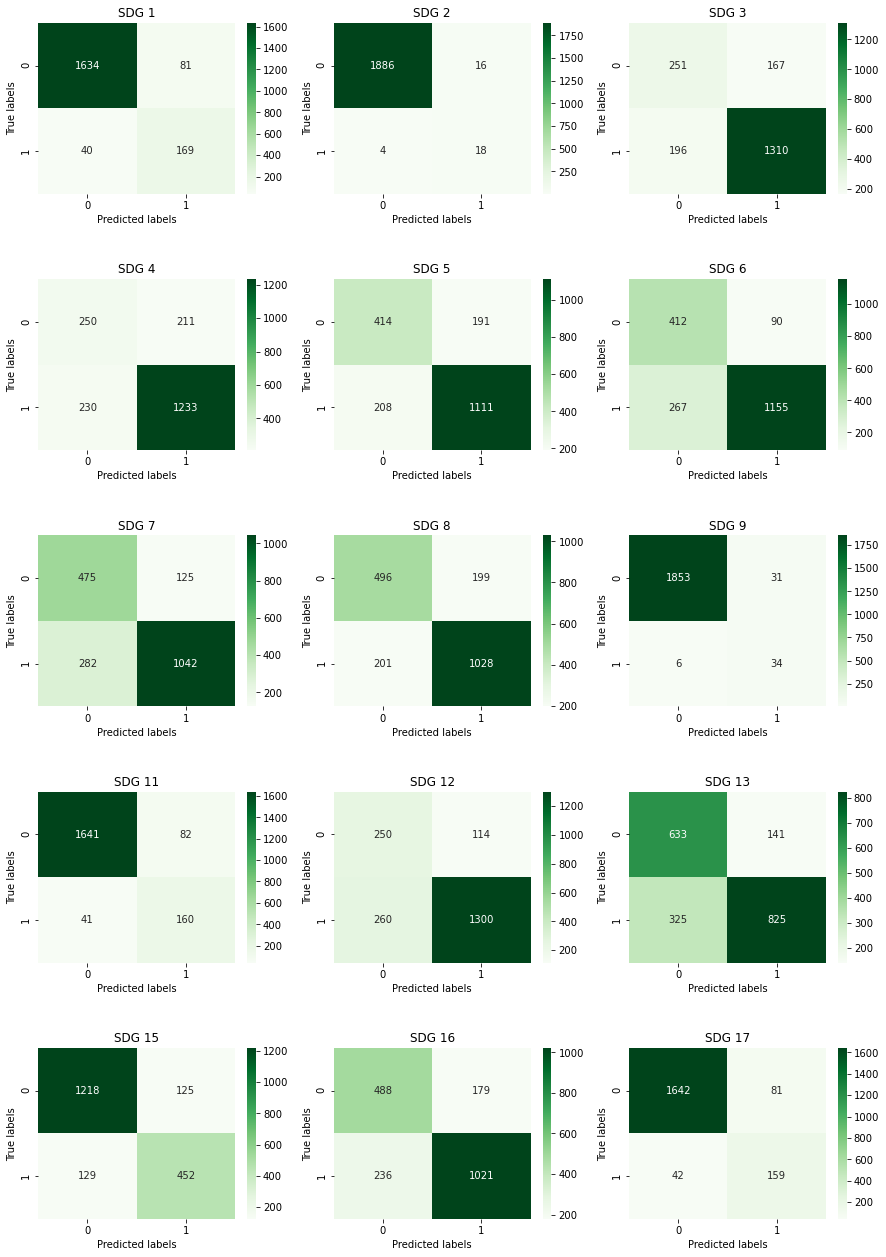

In [34]:
# Evaluation
predictions = grid_search.predict(X_test)
print(classification_report(Y_test, predictions))

sdgs = [1,2,3,4,5,6,7,8,9,11,12,13,15,16,17]
counter = 0
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,22))
plt.subplots_adjust(hspace = 0.5)
for ax in axes.flatten():
    cm = confusion_matrix(Y_test[:,counter], predictions[:,counter])
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Greens')
    ax.set_title('SDG ' + str(sdgs[counter]))
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    counter += 1

In [64]:
# Look at 10 most important words for each SDG (for logistic regression)
i = 0
for sdg in labels:
    coefs = grid_search.best_estimator_.estimators_[i].named_steps['clf'].coef_[0]
    important_tokens = pd.DataFrame(data = coefs, index=tfidf.get_feature_names(), columns=['coefficient']).sort_values(by='coefficient', ascending=False)
    print(sdg)
    print(list(important_tokens.index)[0:10])
    print('\n')
    i += 1

SDG_1
['banking', 'stagecoach', 'barratt', 'st', 'unilever', 'countryside', 'financial', 'rbc', 'customer', 'jetblue']


SDG_2
['johnson', 'food', 'dupont', 'cv', 'smucker', 'cranswick', 'greggs', 'adm', 'ambev', 'consumer']


SDG_3
['safety', 'supplier', 'health', 'water', 'site', 'cibc', 'sustainability', 'chain', 'mine', 'mining']


SDG_4
['employee', 'supplier', 'gri', 'client', 'training', 'management', 'climate', 'service', 'risk', 'million']


SDG_5
['supplier', 'global', 'right', 'human', 'chain', 'sustainable', 'goal', 'supply', 'labor', 'product']


SDG_6
['water', 'supplier', 'chain', 'supply', 'gri', 'site', 'product', 'cibc', 'environmental', 'mine']


SDG_7
['renewable', 'energy', 'product', 'global', 'sustainable', 'solar', 'cibc', 'million', 'bluescope', 'sony']


SDG_8
['human', 'right', 'supplier', 'global', 'chain', 'supply', 'labor', 'risk', 'covid', 'sustainable']


SDG_9
['cnh', 'colgate', 'allstate', 'shinhan', 'autodesk', 'prudential', 'banking', 'johnson', 'pnc

## 5. Other stuff

In [76]:
# Methode ohne GridSearchCV (stratified)

#from sklearn.naive_bayes import MultinomialNB
#from imblearn.combine import SMOTEENN

from imblearn.pipeline import Pipeline 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score

# This pipeline will resample the data and pass the output to MultinomialNB
pipeline = Pipeline([('smote', SMOTE(k_neighbors = 2)), # change k_neighbors
                     ('clf', LogisticRegression())])

# OVR will transform the `y` as you know and  then pass single label data to different copies of pipe  multiple times (as many labels in data)
clf = OneVsRestClassifier(pipeline)

# k-fold stratified sampling for multi-label
# http://scikit.ml/api/skmultilearn.model_selection.iterative_stratification.html
k_fold = IterativeStratification(n_splits=2, order=1) 

scores = []
for train, test in tqdm(k_fold.split(X, Y)):
    clf.fit(X[train], Y[train])
    pred = clf.predict(X[test])
    scores.append(f1_score(Y[test], pred, average='macro'))
print('Average F1 score: ' + str(np.mean(scores)))

0it [00:00, ?it/s]

Average F1 score: 0.6031969856859423


In [58]:
# Methode ohne Pipeline 

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn.base import clone

sm = SMOTE(random_state=42)
clf_lr = LogisticRegression()
clf_svm = SVC()

# Data: tf-idf
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['CSR_Text_tokenized'])

# Labels: Exclude SDGs 10 and 14
labels = ['SDG_1', 'SDG_2', 'SDG_3', 'SDG_4', 'SDG_5', 'SDG_6', 'SDG_7', 'SDG_8', 'SDG_9', 'SDG_11', 'SDG_12', 'SDG_13', 'SDG_15', 'SDG_16', 'SDG_17']
Y = df[labels].to_numpy().astype(int)

# Classifiers to test
classifiers = [clf_lr, clf_svm]

# Split into training and test data: Replace by cross validation
X_train, Y_train, X_test, Y_test = iterative_train_test_split(X, Y, test_size = 0.2)

# Store predictions
predictions = np.zeros(shape=Y_test.shape) 

for classifier in tqdm(classifiers):
    # Train one independent classifier for each label
    for i in range(Y_train.shape[1]):
        # Apply SMOTE to training data
        X_res, Y_res = sm.fit_resample(X_train, Y_train[:,i])
        # Fit classifier
        model = clone(classifier)
        model.fit(X_res, Y_res)
        # Predict
        pred = new_model.predict(X_test)
        # Store predictions
        predictions[:,i] = pred
        # Print result
    print(classifier)
    print(classification_report(Y_test, predictions))   

  0%|          | 0/2 [00:00<?, ?it/s]

LogisticRegression()
              precision    recall  f1-score   support

           0       0.82      0.45      0.58        20
           1       0.00      0.00      0.00         2
           2       0.55      0.03      0.06       177
           3       0.91      0.06      0.11       171
           4       0.64      0.04      0.08       174
           5       0.36      0.03      0.05       148
           6       0.64      0.05      0.09       140
           7       0.55      0.04      0.07       166
           8       0.18      0.40      0.25         5
           9       0.73      0.44      0.55        18
          10       0.55      0.03      0.07       172
          11       0.64      0.05      0.09       142
          12       0.27      0.05      0.08        66
          13       0.55      0.04      0.07       168
          14       0.73      0.44      0.55        18

   micro avg       0.54      0.06      0.10      1587
   macro avg       0.54      0.14      0.18      1587
weigh

In [ ]:
# Methode ohne Pipeline alt: Check um Models zu speichern

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn.base import clone

sm = SMOTE(random_state=42)
clf_lr = LogisticRegression()
clf_svm = SVC()

# Data: tf-idf
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['CSR_Text_tokenized'])

# Labels: Exclude SDGs 10 and 14
labels = ['SDG_1', 'SDG_2', 'SDG_3', 'SDG_4', 'SDG_5', 'SDG_6', 'SDG_7', 'SDG_8', 'SDG_9', 'SDG_11', 'SDG_12', 'SDG_13', 'SDG_15', 'SDG_16', 'SDG_17']
Y = df[labels].to_numpy().astype(int)

# Split into training and test data: Replace by cross validation
X_train, Y_train, X_test, Y_test = iterative_train_test_split(X, Y, test_size = 0.2)

# Classifiers to test
classifiers = [clf_lr, clf_svm]

# Store models and predictions
predictions_lr = np.zeros(shape=Y_test.shape) 
predictions_svm = np.zeros(shape=Y_test.shape) 
models_lr = [] 
models_svm = [] 

for classifier in tqdm(classifiers):
    # Train one independent classifier for each label
    for i in range(Y_train.shape[1]):
        # Apply SMOTE to training data
        X_res, Y_res = sm.fit_resample(X_train, Y_train[:,i])
        # Fit classifier
        model = clone(classifier)
        model.fit(X_res, Y_res)
        # Predict
        pred = new_model.predict(X_test)
        # Store models, parameters, and predictions
        if classifier == clf_lr:
            models_lr.append(model)
            predictions_lr[:,i] = pred
        elif classifier == clf_svm:
            models_svm.append(model)
            predictions_svm[:,i] = pred
# Print results
print('Logistic Regression')
print(classification_report(Y_test, predictions_lr))
print('SVM')
print(classification_report(Y_test, predictions_svm))  

In [39]:
# TEMP (not so useful) Look at words with highest tf-idf score for each document (does not work for full matrix)

X_tfidf = X.toarray()
vocab = tfidf.vocabulary_
reverse_vocab = {v:k for k,v in vocab.items()}
feature_names = tfidf.get_feature_names()
df_tfidf = pd.DataFrame(X_tfidf, columns = feature_names)

idx = X_tfidf.argsort(axis=1)
tfidf_max10 = idx[:,-10:]

df_tfidf['top10'] = [[reverse_vocab.get(item) for item in row] for row in tfidf_max10 ]
df_tfidf['top10']

0                 [company, million, financial, gibraltar, casino, bingo, poker, group, gaming, gambling]
1                     [business, ayana, program, jinho, product, customer, covid, gri, employee, agilent]
                                                     ...                                                 
98    [client, plc, microfinance, statementsadditional, reportstrategic, loan, group, informationgover...
99              [shipbuilding, slavery, chickasaw, jrotc, risk, esg, alabama, marinelink, vessel, austal]
Name: top10, Length: 100, dtype: object

In [80]:
#Hamming score for multilabel classification

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/float(len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test_tfidf)))
    print("Hamming score: {}".format(hamming_score(y_pred, y_test_tfidf)))
    print("---")    

nb_clf = MultinomialNB()
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=6, tol=None)
lr = LogisticRegression()

for classifier in [nb_clf, sgd, lr]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(x_train_tfidf, y_train_tfidf)
    y_pred = clf.predict(x_test_tfidf)
    print_score(y_pred, classifier)